# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the Wyscout open dataset, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

## Uploading data

In [73]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from collections import Counter
import operator

In [74]:
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']

# loading the events data
events={}
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)
        
# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the competitions data
competitions={}
with open('./data/competitions.json') as json_data:
    competitions = json.load(json_data)

# loading the teams data
teams={}
with open('./data/teams.json') as json_data:
    teams = json.load(json_data)

### Converting the json data to DataFrame

#### Teams

In [3]:
teams_df = pd.DataFrame(teams)

In [4]:
teams_df.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [5]:
teams_df.shape

(142, 6)

In [6]:
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          142 non-null    object
 1   name          142 non-null    object
 2   wyId          142 non-null    int64 
 3   officialName  142 non-null    object
 4   area          142 non-null    object
 5   type          142 non-null    object
dtypes: int64(1), object(5)
memory usage: 6.8+ KB


In [7]:
teams_df.iloc[0]['area']['name']

'England'

#### Competitions

In [8]:
competitions_df = pd.DataFrame(competitions)

In [9]:
competitions_df.shape

(7, 5)

In [10]:
competitions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    7 non-null      object
 1   wyId    7 non-null      int64 
 2   format  7 non-null      object
 3   area    7 non-null      object
 4   type    7 non-null      object
dtypes: int64(1), object(4)
memory usage: 408.0+ bytes


In [11]:
competitions_df

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
5,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international
6,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international


#### Players

In [12]:
players_df = pd.DataFrame(players)

In [13]:
players_df.shape

(3603, 14)

In [14]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   passportArea           3603 non-null   object
 1   weight                 3603 non-null   int64 
 2   firstName              3603 non-null   object
 3   middleName             3603 non-null   object
 4   lastName               3603 non-null   object
 5   currentTeamId          3512 non-null   object
 6   birthDate              3603 non-null   object
 7   height                 3603 non-null   int64 
 8   role                   3603 non-null   object
 9   birthArea              3603 non-null   object
 10  wyId                   3603 non-null   int64 
 11  foot                   3603 non-null   object
 12  shortName              3603 non-null   object
 13  currentNationalTeamId  3603 non-null   object
dtypes: int64(3), object(11)
memory usage: 394.2+ KB


In [15]:
players_df.currentTeamId.value_counts()

currentTeamId
null     44
683      38
712      31
3775     31
3219     31
         ..
14995     1
3167      1
9142      1
3183      1
62943     1
Name: count, Length: 615, dtype: int64

In [16]:
players_df[:3]

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null


In [17]:
players_df[players_df['shortName']=='L. Messi']

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
207,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",72,Lionel Andr\u00e9s,,Messi Cuccittini,676,1987-06-24,170,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Argentina', 'id': '32', 'alpha3code'...",3359,left,L. Messi,12274


In [18]:
teams_df[teams_df['wyId']==676]

,city,name,wyId,officialName,area,type
15,Barcelona,Barcelona,676,FC Barcelona,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


#### Matches
In this case, I split the JSON object in different dataframes

##### Italy

In [19]:
italian_matches_df = pd.DataFrame(matches['Italy'])

In [20]:
italian_matches_df.shape

(380, 14)

In [21]:
italian_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         380 non-null    object
 1   roundId        380 non-null    int64 
 2   gameweek       380 non-null    int64 
 3   teamsData      380 non-null    object
 4   seasonId       380 non-null    int64 
 5   dateutc        380 non-null    object
 6   winner         380 non-null    int64 
 7   venue          380 non-null    object
 8   wyId           380 non-null    int64 
 9   label          380 non-null    object
 10  date           380 non-null    object
 11  referees       380 non-null    object
 12  duration       380 non-null    object
 13  competitionId  380 non-null    int64 
dtypes: int64(6), object(8)
memory usage: 41.7+ KB


In [22]:
italian_matches_df.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406278,38,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",181248,2018-05-20 18:45:00,3161,,2576335,"Lazio - Internazionale, 2 - 3","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377206, 'role': 'referee'}, {'r...",Regular,524
1,Played,4406278,38,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",181248,2018-05-20 18:45:00,3158,MAPEI Stadium - Citt\u00e0 del Tricolore,2576336,"Sassuolo - Roma, 0 - 1","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377255, 'role': 'referee'}, {'r...",Regular,524
2,Played,4406278,38,"{'3173': {'scoreET': 0, 'coachId': 251044, 'si...",181248,2018-05-20 16:00:00,3173,,2576329,"Cagliari - Atalanta, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377247, 'role': 'referee'}, {'r...",Regular,524
3,Played,4406278,38,"{'3165': {'scoreET': 0, 'coachId': 272970, 'si...",181248,2018-05-20 16:00:00,3165,,2576330,"Chievo - Benevento, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377246, 'role': 'referee'}, {'r...",Regular,524
4,Played,4406278,38,"{'3166': {'scoreET': 0, 'coachId': 20481, 'sid...",181248,2018-05-20 16:00:00,3163,,2576331,"Udinese - Bologna, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377254, 'role': 'referee'}, {'r...",Regular,524


In [23]:
italian_matches_df.status.value_counts()

status
Played    380
Name: count, dtype: int64

In [24]:
italian_matches_df.roundId.value_counts()

roundId
4406278    380
Name: count, dtype: int64

In [25]:
italian_matches_df.seasonId.value_counts()

seasonId
181248    380
Name: count, dtype: int64

In [26]:
italian_matches_df.venue.value_counts()

venue
                                            106
Stadio Comunale Luigi Ferraris               28
Stadio Marc'Antonio Bentegodi                27
Stadio Olimpico                              27
Stadio Giuseppe Meazza                       27
MAPEI Stadium - Citt\u00e0 del Tricolore     15
Stadio Renato Dall'Ara                       15
Stadio Ciro Vigorito                         14
Dacia Arena                                  14
Stadio Olimpico Grande Torino                14
Stadio San Paolo                             14
Stadio Atleti Azzurri d'Italia               14
Allianz Stadium                              13
Sardegna Arena                               13
Stadio Artemio Franchi                       13
Stadio Ezio Scida                            13
Stadio Paolo Mazza                           12
Stadio Ciro Vigorito                          1
Name: count, dtype: int64

In [27]:
italian_matches_df.duration.value_counts()

duration
Regular    380
Name: count, dtype: int64

In [28]:
italian_matches_df.competitionId.value_counts()

competitionId
524    380
Name: count, dtype: int64

In [29]:
italian_matches_df.seasonId.value_counts()

seasonId
181248    380
Name: count, dtype: int64

In [30]:
italian_matches_df.drop(['status', 'roundId', 'seasonId', 'venue', 'duration', 'competitionId', 'referees'], axis=1, inplace=True)

In [31]:
italian_matches_df.head()

,gameweek,teamsData,dateutc,winner,wyId,label,date
0,38,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",2018-05-20 18:45:00,3161,2576335,"Lazio - Internazionale, 2 - 3","May 20, 2018 at 8:45:00 PM GMT+2"
1,38,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",2018-05-20 18:45:00,3158,2576336,"Sassuolo - Roma, 0 - 1","May 20, 2018 at 8:45:00 PM GMT+2"
2,38,"{'3173': {'scoreET': 0, 'coachId': 251044, 'si...",2018-05-20 16:00:00,3173,2576329,"Cagliari - Atalanta, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2"
3,38,"{'3165': {'scoreET': 0, 'coachId': 272970, 'si...",2018-05-20 16:00:00,3165,2576330,"Chievo - Benevento, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2"
4,38,"{'3166': {'scoreET': 0, 'coachId': 20481, 'sid...",2018-05-20 16:00:00,3163,2576331,"Udinese - Bologna, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2"


In [32]:
italian_matches_df['teamsData'][0].keys()

dict_keys(['3162', '3161'])

In [33]:
players_df[players_df['wyId']==352993]

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
1886,"{'name': 'France', 'id': '250', 'alpha3code': ...",77,Yann,,Karamoh,3161,1998-07-08,185,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'C\u00f4te d'Ivoire', 'id': '384', 'a...",352993,right,Y. Karamoh,null


In [34]:
teams_df[teams_df['wyId']==3162]

,city,name,wyId,officialName,area,type
51,Formello,Lazio,3162,SS Lazio,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club


##### England

In [35]:
english_matches_df = pd.DataFrame(matches['England'])

In [36]:
english_matches_df.shape

(380, 14)

In [37]:
english_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         380 non-null    object
 1   roundId        380 non-null    int64 
 2   gameweek       380 non-null    int64 
 3   teamsData      380 non-null    object
 4   seasonId       380 non-null    int64 
 5   dateutc        380 non-null    object
 6   winner         380 non-null    int64 
 7   venue          380 non-null    object
 8   wyId           380 non-null    int64 
 9   label          380 non-null    object
 10  date           380 non-null    object
 11  referees       380 non-null    object
 12  duration       380 non-null    object
 13  competitionId  380 non-null    int64 
dtypes: int64(6), object(8)
memory usage: 41.7+ KB


In [38]:
english_matches_df.status.value_counts()

status
Played    380
Name: count, dtype: int64

In [39]:
english_matches_df.roundId.value_counts()

roundId
4405654    380
Name: count, dtype: int64

In [40]:
english_matches_df.seasonId.value_counts()

seasonId
181150    380
Name: count, dtype: int64

In [41]:
english_matches_df.duration.value_counts()

duration
Regular    380
Name: count, dtype: int64

In [42]:
english_matches_df.competitionId.value_counts()

competitionId
364    380
Name: count, dtype: int64

In [43]:
english_matches_df.drop(['status', 'roundId', 'seasonId', 'venue', 'duration', 'competitionId', 'referees'], axis=1, inplace=True)

In [44]:
english_matches_df.head()

,gameweek,teamsData,dateutc,winner,wyId,label,date
0,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",2018-05-13 14:00:00,1659,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2"
1,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",2018-05-13 14:00:00,1628,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2"
2,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",2018-05-13 14:00:00,1609,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2"
3,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",2018-05-13 14:00:00,1612,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2"
4,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",2018-05-13 14:00:00,1611,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2"


##### Germany

In [45]:
german_matches_df = pd.DataFrame(matches['Germany'])

In [46]:
german_matches_df.shape

(306, 14)

In [47]:
german_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         306 non-null    object
 1   roundId        306 non-null    int64 
 2   gameweek       306 non-null    int64 
 3   teamsData      306 non-null    object
 4   seasonId       306 non-null    int64 
 5   dateutc        306 non-null    object
 6   winner         306 non-null    int64 
 7   venue          306 non-null    object
 8   wyId           306 non-null    int64 
 9   label          306 non-null    object
 10  date           306 non-null    object
 11  referees       306 non-null    object
 12  duration       306 non-null    object
 13  competitionId  306 non-null    int64 
dtypes: int64(6), object(8)
memory usage: 33.6+ KB


In [48]:
german_matches_df.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405517,34,"{'2444': {'scoreET': 0, 'coachId': 14710, 'sid...",181137,2018-05-12 13:30:00,2445,Allianz Arena,2517036,"Bayern M\u00fcnchen - Stuttgart, 1 - 4","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 379444, 'role': 'referee'}, {'r...",Regular,426
1,Played,4405517,34,"{'2482': {'scoreET': 0, 'coachId': 272299, 'si...",181137,2018-05-12 13:30:00,2482,WIRSOL Rhein-Neckar-Arena,2517037,"Hoffenheim - Borussia Dortmund, 3 - 1","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 384936, 'role': 'referee'}, {'r...",Regular,426
2,Played,4405517,34,"{'2457': {'scoreET': 0, 'coachId': 18987, 'sid...",181137,2018-05-12 13:30:00,2975,Olympiastadion Berlin,2517038,"Hertha BSC - RB Leipzig, 2 - 6","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387276, 'role': 'referee'}, {'r...",Regular,426
3,Played,4405517,34,"{'2453': {'scoreET': 0, 'coachId': 14977, 'sid...",181137,2018-05-12 13:30:00,2453,Schwarzwald-Stadion,2517039,"Freiburg - Augsburg, 2 - 0","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 378957, 'role': 'referee'}, {'r...",Regular,426
4,Played,4405517,34,"{'2449': {'scoreET': 0, 'coachId': 447924, 'si...",181137,2018-05-12 13:30:00,2449,VELTINS-Arena,2517040,"Schalke 04 - Eintracht Frankfurt, 1 - 0","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387273, 'role': 'referee'}, {'r...",Regular,426


In [49]:
german_matches_df.status.value_counts()

status
Played    306
Name: count, dtype: int64

In [50]:
german_matches_df.seasonId.value_counts()

seasonId
181137    306
Name: count, dtype: int64

In [51]:
german_matches_df.duration.value_counts()

duration
Regular    306
Name: count, dtype: int64

In [52]:
german_matches_df.venue.value_counts()

venue
Allianz Arena                17
WIRSOL Rhein-Neckar-Arena    17
HDI-Arena                    17
WWK Arena                    17
Commerzbank-Arena            17
Stadion im BORUSSIA-PARK     17
Weserstadion                 17
RheinEnergieStadion          17
Red Bull Arena               17
Signal-Iduna-Park            17
VOLKSWAGEN ARENA             17
OPEL ARENA                   17
Volksparkstadion             17
BayArena                     17
VELTINS-Arena                17
Schwarzwald-Stadion          17
Olympiastadion Berlin        17
Mercedes-Benz-Arena          17
Name: count, dtype: int64

In [53]:
german_matches_df.duration.value_counts()

duration
Regular    306
Name: count, dtype: int64

In [54]:
german_matches_df.competitionId.value_counts()

competitionId
426    306
Name: count, dtype: int64

In [55]:
german_matches_df.drop(['status', 'roundId', 'seasonId', 'venue', 'duration', 'competitionId', 'referees'], axis=1, inplace=True)

In [56]:
german_matches_df.head()

,gameweek,teamsData,dateutc,winner,wyId,label,date
0,34,"{'2444': {'scoreET': 0, 'coachId': 14710, 'sid...",2018-05-12 13:30:00,2445,2517036,"Bayern M\u00fcnchen - Stuttgart, 1 - 4","May 12, 2018 at 3:30:00 PM GMT+2"
1,34,"{'2482': {'scoreET': 0, 'coachId': 272299, 'si...",2018-05-12 13:30:00,2482,2517037,"Hoffenheim - Borussia Dortmund, 3 - 1","May 12, 2018 at 3:30:00 PM GMT+2"
2,34,"{'2457': {'scoreET': 0, 'coachId': 18987, 'sid...",2018-05-12 13:30:00,2975,2517038,"Hertha BSC - RB Leipzig, 2 - 6","May 12, 2018 at 3:30:00 PM GMT+2"
3,34,"{'2453': {'scoreET': 0, 'coachId': 14977, 'sid...",2018-05-12 13:30:00,2453,2517039,"Freiburg - Augsburg, 2 - 0","May 12, 2018 at 3:30:00 PM GMT+2"
4,34,"{'2449': {'scoreET': 0, 'coachId': 447924, 'si...",2018-05-12 13:30:00,2449,2517040,"Schalke 04 - Eintracht Frankfurt, 1 - 0","May 12, 2018 at 3:30:00 PM GMT+2"


##### France

In [57]:
french_matches_df = pd.DataFrame(matches['France'])

In [58]:
french_matches_df.shape

(380, 14)

In [59]:
french_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         380 non-null    object
 1   roundId        380 non-null    int64 
 2   gameweek       380 non-null    int64 
 3   teamsData      380 non-null    object
 4   seasonId       380 non-null    int64 
 5   dateutc        380 non-null    object
 6   winner         380 non-null    int64 
 7   venue          380 non-null    object
 8   wyId           380 non-null    int64 
 9   label          380 non-null    object
 10  date           380 non-null    object
 11  referees       380 non-null    object
 12  duration       380 non-null    object
 13  competitionId  380 non-null    int64 
dtypes: int64(6), object(8)
memory usage: 41.7+ KB


In [60]:
french_matches_df.status.value_counts()

status
Played    380
Name: count, dtype: int64

In [61]:
french_matches_df.roundId.value_counts()

roundId
4405655    380
Name: count, dtype: int64

In [62]:
french_matches_df.seasonId.value_counts()

seasonId
181189    380
Name: count, dtype: int64

In [63]:
french_matches_df.duration.value_counts()

duration
Regular    380
Name: count, dtype: int64

In [64]:
french_matches_df.venue.value_counts()

venue
Stade Michel d'Ornano                      19
Stade Gaston-G\u00e9rard                   19
Stade de la Meinau                         19
Parc des Princes                           19
Allianz Riviera                            19
Stade de la Mosson                         19
Stade Louis II.                            19
Stade Pierre-Mauroy                        19
Stade Matmut-Atlantique                    19
Stade Raymond Kopa                         19
Stade de la Licorne                        19
Stade de l'Aube                            19
Stadium Municipal                          19
Stade Geoffroy-Guichard                    19
Roazhon Park                               19
Stade de la Beaujoire - Louis Fonteneau    19
Stade Saint-Symphorien                     19
Stade V\u00e9lodrome                       19
Groupama Stadium                           19
Stade du Roudourou                         19
Name: count, dtype: int64

In [65]:
french_matches_df.duration.value_counts()

duration
Regular    380
Name: count, dtype: int64

In [66]:
french_matches_df.competitionId.value_counts()

competitionId
412    380
Name: count, dtype: int64

In [67]:
french_matches_df.drop(['status', 'roundId', 'seasonId', 'venue', 'duration', 'competitionId', 'referees'], axis=1, inplace=True)

In [68]:
french_matches_df.head()

,gameweek,teamsData,dateutc,winner,wyId,label,date
0,38,"{'3783': {'scoreET': 0, 'coachId': 210513, 'si...",2018-05-19 19:00:00,0,2501056,"Caen - PSG, 0 - 0","May 19, 2018 at 9:00:00 PM GMT+2"
1,38,"{'3804': {'scoreET': 0, 'coachId': 220743, 'si...",2018-05-19 19:00:00,0,2501057,"Dijon - Angers SCO, 2 - 1","May 19, 2018 at 9:00:00 PM GMT+2"
2,38,"{'3766': {'scoreET': 0, 'coachId': 211238, 'si...",2018-05-19 19:00:00,3766,2501058,"Olympique Lyonnais - Nice, 3 - 2","May 19, 2018 at 9:00:00 PM GMT+2"
3,38,"{'3771': {'scoreET': 0, 'coachId': 25691, 'sid...",2018-05-19 19:00:00,3771,2501059,"Olympique Marseille - Amiens SC, 2 - 1","May 19, 2018 at 9:00:00 PM GMT+2"
4,38,"{'3772': {'scoreET': 0, 'coachId': 9092, 'side...",2018-05-19 19:00:00,3772,2501060,"Metz - Bordeaux, 0 - 4","May 19, 2018 at 9:00:00 PM GMT+2"


##### Spain

In [69]:
spanish_matches_df = pd.DataFrame(matches['Spain'])

In [70]:
spanish_matches_df.shape

(380, 14)

In [71]:
spanish_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         380 non-null    object
 1   roundId        380 non-null    int64 
 2   gameweek       380 non-null    int64 
 3   teamsData      380 non-null    object
 4   seasonId       380 non-null    int64 
 5   dateutc        380 non-null    object
 6   winner         380 non-null    int64 
 7   venue          380 non-null    object
 8   wyId           380 non-null    int64 
 9   label          380 non-null    object
 10  date           380 non-null    object
 11  referees       380 non-null    object
 12  duration       380 non-null    object
 13  competitionId  380 non-null    int64 
dtypes: int64(6), object(8)
memory usage: 41.7+ KB


In [72]:
spanish_matches_df.status.value_counts()

status
Played    380
Name: count, dtype: int64

In [73]:
spanish_matches_df.roundId.value_counts()

roundId
4406122    380
Name: count, dtype: int64

In [74]:
spanish_matches_df.seasonId.value_counts()

seasonId
181144    380
Name: count, dtype: int64

In [75]:
spanish_matches_df.duration.value_counts()

duration
Regular    380
Name: count, dtype: int64

In [76]:
spanish_matches_df.venue.value_counts()

venue
Camp Nou                                        19
Estadio Wanda Metropolitano                     19
Estadio Municipal de Ipur\u00faa                19
Estadio Benito Villamar\u00edn                  19
Coliseum Alfonso P\u00e9rez                     19
Estadio Municipal de Riazor                     19
Estadio de Mendizorroza                         19
Estadi Municipal de Montilivi                   19
Estadio Santiago Bernab\u00e9u                  19
RCDE Stadium                                    19
Estadio Ciudad de Valencia                      19
Estadio de Bala\u00eddos                        19
Estadio Municipal de Butarque                   19
Estadio de Gran Canaria                         19
Estadio La Rosaleda                             19
Estadio Ram\u00f3n S\u00e1nchez Pizju\u00e1n    19
Estadio de la Cer\u00e1mica                     19
Estadio de Mestalla                             19
San Mam\u00e9s Barria                           19
Estadio Municipal de Anoe

In [77]:
spanish_matches_df.competitionId.value_counts()

competitionId
795    380
Name: count, dtype: int64

In [78]:
spanish_matches_df.drop(['status', 'roundId', 'seasonId', 'venue', 'duration', 'competitionId', 'referees'], axis=1, inplace=True)

In [79]:
spanish_matches_df.head()

,gameweek,teamsData,dateutc,winner,wyId,label,date
0,38,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",2018-05-20 18:45:00,676,2565922,"Barcelona - Real Sociedad, 1 - 0","May 20, 2018 at 8:45:00 PM GMT+2"
1,38,"{'679': {'scoreET': 0, 'coachId': 3427, 'side'...",2018-05-20 16:30:00,0,2565925,"Atl\u00e9tico Madrid - Eibar, 2 - 2","May 20, 2018 at 6:30:00 PM GMT+2"
2,38,"{'691': {'scoreET': 0, 'coachId': 444778, 'sid...",2018-05-20 14:15:00,691,2565919,"Athletic Club - Espanyol, 0 - 1","May 20, 2018 at 4:15:00 PM GMT+2"
3,38,"{'674': {'scoreET': 0, 'coachId': 210074, 'sid...",2018-05-20 10:00:00,674,2565924,"Valencia - Deportivo La Coru\u00f1a, 2 - 1","May 20, 2018 at 12:00:00 PM GMT+2"
4,38,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",2018-05-19 18:45:00,0,2565927,"Villarreal - Real Madrid, 2 - 2","May 19, 2018 at 8:45:00 PM GMT+2"


##### European Championship

In [80]:
european_matches_df = pd.DataFrame(matches['European_Championship'])

In [81]:
european_matches_df.shape

(51, 15)

In [82]:
european_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         51 non-null     object
 1   roundId        51 non-null     int64 
 2   gameweek       51 non-null     int64 
 3   teamsData      51 non-null     object
 4   seasonId       51 non-null     int64 
 5   dateutc        51 non-null     object
 6   winner         51 non-null     int64 
 7   venue          51 non-null     object
 8   wyId           51 non-null     int64 
 9   label          51 non-null     object
 10  date           51 non-null     object
 11  groupName      51 non-null     object
 12  referees       51 non-null     object
 13  duration       51 non-null     object
 14  competitionId  51 non-null     int64 
dtypes: int64(6), object(9)
memory usage: 6.1+ KB


In [83]:
european_matches_df.status.value_counts()

status
Played    51
Name: count, dtype: int64

In [84]:
european_matches_df.roundId.value_counts()

roundId
4165470    36
4165471     8
4165472     4
4165473     2
4165474     1
Name: count, dtype: int64

In [85]:
dictionary = {}
for item in european_matches_df.teamsData:
    first = list(item.keys())[0]
    second = list(item.keys())[1]
    if first in dictionary:
        dictionary[first] += 1
    else:  
        dictionary[first] = 1
    if second in dictionary:
        dictionary[second] += 1
    else:
        dictionary[second] = 1

In [86]:
dictionary

{'9905': 7,
 '4418': 7,
 '3148': 6,
 '10682': 6,
 '7839': 5,
 '3757': 5,
 '5629': 5,
 '13869': 5,
 '2413': 4,
 '1598': 4,
 '10451': 4,
 '14496': 4,
 '8274': 4,
 '9598': 4,
 '10962': 4,
 '6697': 4,
 '7047': 3,
 '9109': 3,
 '4687': 3,
 '11555': 3,
 '14622': 3,
 '14358': 3,
 '11944': 3,
 '8731': 3}

In [87]:
european_matches_df.seasonId.value_counts()

seasonId
9291    51
Name: count, dtype: int64

In [88]:
european_matches_df.venue.value_counts()

venue
Stade de France            7
Stade V\u00e9lodrome       6
Groupama Stadium           6
Stade Pierre-Mauroy        6
Stade Matmut-Atlantique    5
Parc des Princes           5
Allianz Riviera            4
Stadium Municipal          4
Stade Bollaert-Delelis     4
Stade Geoffroy-Guichard    4
Name: count, dtype: int64

In [89]:
european_matches_df.groupName.value_counts()

groupName
Group F    21
Group E     6
Group D     6
Group C     6
Group B     6
Group A     6
Name: count, dtype: int64

In [90]:
european_matches_df.duration.value_counts()

duration
Regular      46
Penalties     3
ExtraTime     2
Name: count, dtype: int64

In [91]:
european_matches_df.competitionId.value_counts()

competitionId
102    51
Name: count, dtype: int64

In [92]:
european_matches_df.drop(['status', 'seasonId', 'venue', 'competitionId', 'referees', 'groupName'], axis=1, inplace=True)

In [93]:
european_matches_df.head()

,roundId,gameweek,teamsData,dateutc,winner,wyId,label,date,duration
0,4165474,0,"{'9905': {'scoreET': 1, 'coachId': 137521, 'si...",2016-07-10 19:00:00,9905,1694440,"Portugal - France, 1 - 0 (E)","July 10, 2016 at 9:00:00 PM GMT+2",ExtraTime
1,4165473,0,"{'3148': {'scoreET': 0, 'coachId': 134365, 'si...",2016-07-07 19:00:00,4418,1694439,"Germany - France, 0 - 2","July 7, 2016 at 9:00:00 PM GMT+2",Regular
2,4165473,0,"{'10682': {'scoreET': 0, 'coachId': 136439, 's...",2016-07-06 19:00:00,9905,1694438,"Portugal - Wales, 2 - 0","July 6, 2016 at 9:00:00 PM GMT+2",Regular
3,4165472,0,"{'7839': {'scoreET': 0, 'coachId': 210205, 'si...",2016-07-03 19:00:00,4418,1694437,"France - Iceland, 5 - 2","July 3, 2016 at 9:00:00 PM GMT+2",Regular
4,4165472,0,"{'3148': {'scoreET': 1, 'coachId': 134365, 'si...",2016-07-02 19:00:00,3148,1694436,"Germany - Italy, 1 - 1 (P)","July 2, 2016 at 9:00:00 PM GMT+2",Penalties


##### World Cup

In [94]:
world_cup_df = pd.DataFrame(matches['World_Cup'])

In [95]:
world_cup_df.shape

(64, 15)

In [96]:
world_cup_df.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,groupName,referees,duration,competitionId
0,Played,4165368,0,"{'9598': {'scoreET': 0, 'coachId': 122788, 'si...",10078,2018-07-15 15:00:00,4418,Olimpiyskiy stadion Luzhniki,2058017,"France - Croatia, 4 - 2","July 15, 2018 at 5:00:00 PM GMT+2",,"[{'refereeId': 378051, 'role': 'referee'}, {'r...",Regular,28
1,Played,4165367,0,"{'2413': {'scoreET': 0, 'coachId': 276858, 'si...",10078,2018-07-14 14:00:00,5629,Stadion Krestovskyi,2058016,"Belgium - England, 2 - 0","July 14, 2018 at 4:00:00 PM GMT+2",,"[{'refereeId': 380599, 'role': 'referee'}, {'r...",Regular,28
2,Played,4165366,0,"{'2413': {'scoreET': 1, 'coachId': 276858, 'si...",10078,2018-07-11 18:00:00,9598,Olimpiyskiy stadion Luzhniki,2058015,"Croatia - England, 2 - 1 (E)","July 11, 2018 at 8:00:00 PM GMT+2",,"[{'refereeId': 384995, 'role': 'referee'}, {'r...",ExtraTime,28
3,Played,4165366,0,"{'5629': {'scoreET': 0, 'coachId': 8605, 'side...",10078,2018-07-10 18:00:00,4418,Stadion Krestovskyi,2058014,"France - Belgium, 1 - 0","July 10, 2018 at 8:00:00 PM GMT+2",,"[{'refereeId': 378232, 'role': 'referee'}, {'r...",Regular,28
4,Played,4165365,0,"{'14358': {'scoreET': 2, 'coachId': 264893, 's...",10078,2018-07-07 18:00:00,9598,Olimpiyskiy Stadion Fisht,2058012,"Russia - Croatia, 2 - 2 (P)","July 7, 2018 at 8:00:00 PM GMT+2",,"[{'refereeId': 378204, 'role': 'referee'}, {'r...",Penalties,28


In [97]:
world_cup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         64 non-null     object
 1   roundId        64 non-null     int64 
 2   gameweek       64 non-null     int64 
 3   teamsData      64 non-null     object
 4   seasonId       64 non-null     int64 
 5   dateutc        64 non-null     object
 6   winner         64 non-null     int64 
 7   venue          64 non-null     object
 8   wyId           64 non-null     int64 
 9   label          64 non-null     object
 10  date           64 non-null     object
 11  groupName      64 non-null     object
 12  referees       64 non-null     object
 13  duration       64 non-null     object
 14  competitionId  64 non-null     int64 
dtypes: int64(6), object(9)
memory usage: 7.6+ KB


In [98]:
world_cup_df.status.value_counts()

status
Played    64
Name: count, dtype: int64

In [99]:
world_cup_df.roundId.value_counts()

roundId
4165363    48
4165364     8
4165365     4
4165366     2
4165368     1
4165367     1
Name: count, dtype: int64

In [100]:
world_cup_df.gameweek.value_counts()

gameweek
0    16
3    16
2    16
1    16
Name: count, dtype: int64

In [101]:
world_cup_df.seasonId.value_counts()

seasonId
10078    64
Name: count, dtype: int64

In [102]:
world_cup_df.venue.value_counts()

venue
Stadion Krestovskyi             7
Olimpiyskiy stadion Luzhniki    6
Olimpiyskiy Stadion Fisht       6
Samara Arena                    6
Kazan' Arena                    6
Stadion Nizhny Novgorod         6
Otkrytiye Arena                 5
Rostov Arena                    5
Kaliningrad Stadium             4
Mordovia Arena                  4
Volgograd Arena                 4
Stadion Central'nyj             4
Stadion Luzhniki                1
Name: count, dtype: int64

In [103]:
world_cup_df.groupName.value_counts()

groupName
           16
Group G     6
Group H     6
Group E     6
Group F     6
Group D     6
Group C     6
Group B     6
Group A     6
Name: count, dtype: int64

In [104]:
world_cup_df.duration.value_counts()

duration
Regular      59
Penalties     4
ExtraTime     1
Name: count, dtype: int64

In [105]:
world_cup_df.competitionId.value_counts()

competitionId
28    64
Name: count, dtype: int64

In [106]:
world_cup_df.drop(['status', 'seasonId', 'venue', 'competitionId', 'referees'], axis=1, inplace=True)

In [107]:
world_cup_df.head()

,roundId,gameweek,teamsData,dateutc,winner,wyId,label,date,groupName,duration
0,4165368,0,"{'9598': {'scoreET': 0, 'coachId': 122788, 'si...",2018-07-15 15:00:00,4418,2058017,"France - Croatia, 4 - 2","July 15, 2018 at 5:00:00 PM GMT+2",,Regular
1,4165367,0,"{'2413': {'scoreET': 0, 'coachId': 276858, 'si...",2018-07-14 14:00:00,5629,2058016,"Belgium - England, 2 - 0","July 14, 2018 at 4:00:00 PM GMT+2",,Regular
2,4165366,0,"{'2413': {'scoreET': 1, 'coachId': 276858, 'si...",2018-07-11 18:00:00,9598,2058015,"Croatia - England, 2 - 1 (E)","July 11, 2018 at 8:00:00 PM GMT+2",,ExtraTime
3,4165366,0,"{'5629': {'scoreET': 0, 'coachId': 8605, 'side...",2018-07-10 18:00:00,4418,2058014,"France - Belgium, 1 - 0","July 10, 2018 at 8:00:00 PM GMT+2",,Regular
4,4165365,0,"{'14358': {'scoreET': 2, 'coachId': 264893, 's...",2018-07-07 18:00:00,9598,2058012,"Russia - Croatia, 2 - 2 (P)","July 7, 2018 at 8:00:00 PM GMT+2",,Penalties


#### Events

In [108]:
events['Italy']

[{'eventId': 8,
  'subEventName': 'Simple pass',
  'tags': [{'id': 1801}],
  'playerId': 8327,
  'positions': [{'y': 52, 'x': 49}, {'y': 44, 'x': 43}],
  'matchId': 2575959,
  'eventName': 'Pass',
  'teamId': 3158,
  'matchPeriod': '1H',
  'eventSec': 2.5305359999999837,
  'subEventId': 85,
  'id': 180423957},
 {'eventId': 8,
  'subEventName': 'Simple pass',
  'tags': [{'id': 1801}],
  'playerId': 20438,
  'positions': [{'y': 44, 'x': 43}, {'y': 17, 'x': 36}],
  'matchId': 2575959,
  'eventName': 'Pass',
  'teamId': 3158,
  'matchPeriod': '1H',
  'eventSec': 3.768417999999997,
  'subEventId': 85,
  'id': 180423958},
 {'eventId': 7,
  'subEventName': 'Touch',
  'tags': [],
  'playerId': 8306,
  'positions': [{'y': 17, 'x': 36}, {'y': 56, 'x': 78}],
  'matchId': 2575959,
  'eventName': 'Others on the ball',
  'teamId': 3158,
  'matchPeriod': '1H',
  'eventSec': 4.868265000000008,
  'subEventId': 72,
  'id': 180423959},
 {'eventId': 1,
  'subEventName': 'Ground attacking duel',
  'tags': 

In [109]:
len(events['Italy'])

647372

In [110]:
italian_events_df = pd.DataFrame(events['Italy'])

In [111]:
italian_events_df.iloc[0]

eventId                                                8
subEventName                                 Simple pass
tags                                      [{'id': 1801}]
playerId                                            8327
positions       [{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]
matchId                                          2575959
eventName                                           Pass
teamId                                              3158
matchPeriod                                           1H
eventSec                                        2.530536
subEventId                                            85
id                                             180423957
Name: 0, dtype: object

In [112]:
players_df[players_df['wyId']==italian_events_df.iloc[0]['playerId']]

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
729,"{'name': 'Bosnia-Herzegovina', 'id': '70', 'al...",84,Edin,,D\u017eeko,3158,1986-03-17,193,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Bosnia-Herzegovina', 'id': '70', 'al...",8327,right,E. D\u017eeko,10001


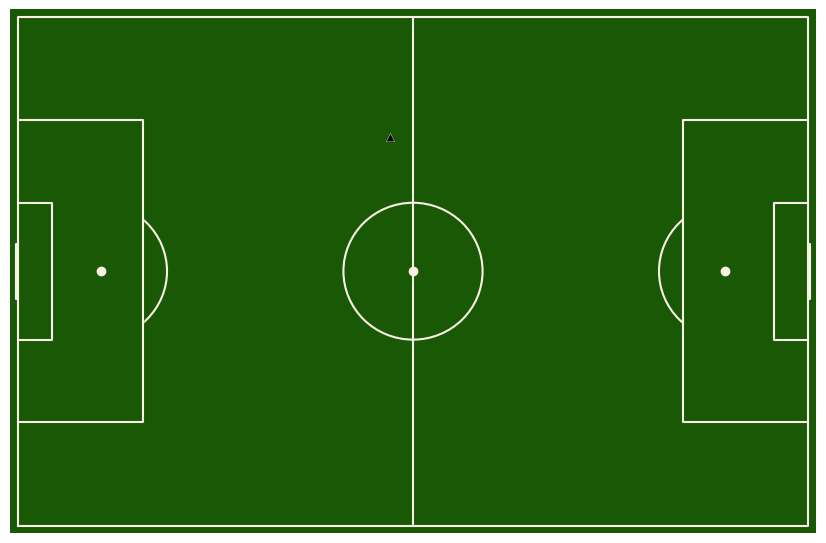

In [129]:
f = draw_pitch("#195905", "#faf0e6", "h", "full")
plt.scatter(49, 52, marker='^', c='k', edgecolors="w", linewidth=0.25, zorder=12)

## Championships/Cups analysis

### Italian division

players_dict = {}
for italian

## Tests

In [38]:
def draw_pitch(pitch, line, orientation, view):
    """
    Draw a soccer pitch given the pitch, the orientation, the view and the line
    
    Parameters
    ----------
    pitch
    
    """
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

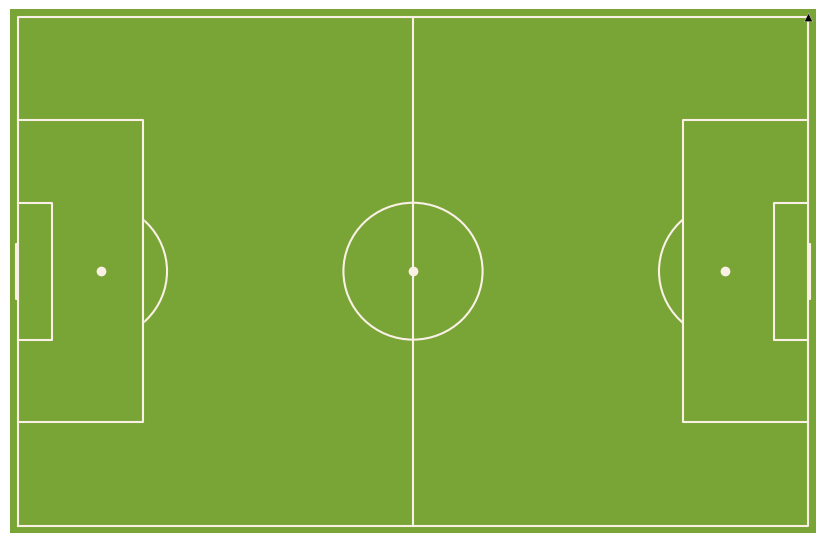

In [72]:
f = draw_pitch("#79A537", "#faf0e6", "h", "full")
plt.scatter(104, 68, marker='^', c='k', edgecolors="w", linewidth=0.25, zorder=12)